
# Title:California Housing Price Predictor
**Name:** Naomi Jepkorir Kimaiyo

**Date:** 14 July 2025

## Project Description
This project builds a machine learning pipeline to predict median house values in California using the 1990 Census data.

The dataset contains demographic and geographic information such as median income, average rooms, latitude/longitude, and more. The goal is to train a regression model using scikit-learn that can accurately estimate housing prices.

The main steps include:
- Exploratory Data Analysis (EDA)
- Preprocessing with `Pipeline` and `ColumnTransformer`
- Model training using `KNeighborsRegressor`
- Hyperparameter tuning via `GridSearchCV`
- Evaluation on a test set
- Saving the trained pipeline for deployment

In [1]:
import pandas as pd
import pickle
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Dataset Overview

We use the built-in `fetch_california_housing()` function from `sklearn.datasets`. The dataset includes:

- 20,640 samples
- 8 numerical features
- Target: Median house value (in $100,000s)

Features:
- `MedInc`: Median income
- `HouseAge`: Median house age
- `AveRooms`: Average number of rooms
- `AveBedrms`: Average number of bedrooms
- `Population`: Block group population
- `AveOccup`: Average household size
- `Latitude` & `Longitude`: Geographic location

In [2]:
# load the dataset
X, y = fetch_california_housing(return_X_y=True, as_frame=True)


In [3]:
print("Feature shape: " , X.shape)
print("Target shape: " , y.shape)

Feature shape:  (20640, 8)
Target shape:  (20640,)


In [4]:
#preview data
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
#check missing
X.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [7]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


## Exploratory Data Analysis (EDA)

We visualize the target distribution and check basic statistics to understand data characteristics and potential preprocessing needs.


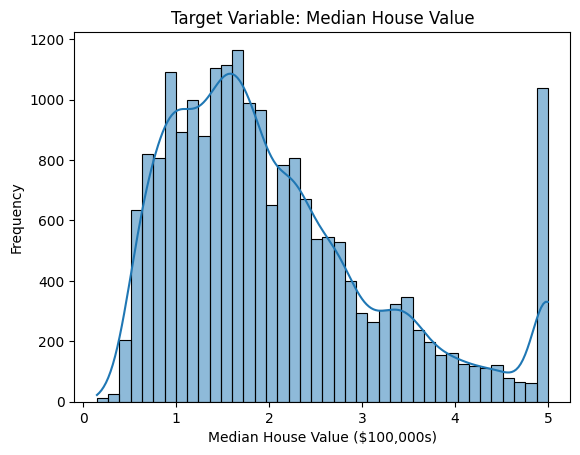

In [12]:
# target variable distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y, bins=40, kde=True)
plt.title("Target Variable: Median House Value")
plt.xlabel("Median House Value ($100,000s)")
plt.ylabel("Frequency")
plt.show()

In [13]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing
We use a `Pipeline` to apply the following transformations to all numerical features:
- Mean imputation for missing values (though this dataset is clean)
- Standardization using `StandardScaler` to normalize feature scales

This is wrapped in a `ColumnTransformer` for clean integration with the model pipeline.



In [14]:
# preprocessing
numeric_features = X.columns # captures all numerical features (all of them in this case)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])


## K-Nearest Neighbors Model

We use `KNeighborsRegressor` as our base model, wrapped inside a `Pipeline` along with preprocessing.

KNN is a distance-based algorithm, which makes proper scaling essential. We'll tune its hyperparameters using grid search.


In [15]:
# building the pipeline
knn_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

## Hyperparameter Tuning: GridSearchCV

We use 5-fold cross-validation and `GridSearchCV` to find the best combination of:
- Number of neighbors: `[3, 5, 7, 9]`
- Distance metric: Manhattan (`p=1`) vs. Euclidean (`p=2`)
- Weighting scheme: `'uniform'` vs. `'distance'`

Scoring metric: R² (coefficient of determination)


In [16]:
# define hyperparameter grid
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid_search = GridSearchCV(
    estimator  = knn_regressor,
    param_grid = param_grid,
    cv = 5,
    scoring = 'r2',
    verbose= 1,
    n_jobs = -1
)

# fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__n_neighbors': [3, 5, ...], 'regressor__p': [1, 2], 'regressor__weights': ['uniform', 'distance']}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


##  Model Evaluation on Test Set

After tuning, we evaluate the best model on the held-out test set using:
- R² Score
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)

These metrics tell us how well the model generalizes to unseen data.


In [17]:
import numpy as np

# evaluation on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R2 Score: {grid_search.best_score_:.4f}")
print(f"R2 Score:{r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Best parameters: {'regressor__n_neighbors': 9, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best R2 Score: 0.7313
R2 Score:0.7221
MSE: 0.3642
RMSE: 0.6034


##  Saving the Final Model

We save the full model pipeline (preprocessing + trained KNN) using `pickle`. This allows easy reuse or deployment without re-training.


In [18]:
#save the pipeline
with open('carlifornia_knn_regressor.pkl', 'wb') as f:
    pickle.dump(best_model, f
    )

print("Pipeline saved successfully!")

Pipeline saved successfully!


In [19]:
#load model
with open('carlifornia_knn_regressor.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
# test on sample data
sample_input = pd.DataFrame([{
    "MedInc": 3.0,
    "HouseAge": 25.0,
    "AveRooms": 5.0,
    "AveBedrms": 1.0,
    "Population": 1500.0,
    "AveOccup": 3.0,
    "Latitude": 34.0,
    "Longitude": -118.0
}])

prediction = loaded_model.predict(sample_input)[0]
print(f"Predicted Median House Value: ${prediction * 100000:.2f}")

Predicted Median House Value: $200289.69
